## <span style="color:red; font-size:larger;">**Installations & Imports**</span>

In [ ]:
!pip install fairlearn
!pip install shap
!pip install lime
!pip install iris

In [ ]:
import time

import pandas as pd
import numpy as np

import shap
from shap import KernelExplainer
import lime
from lime.lime_tabular import LimeTabularExplainer

import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import plot_tree
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibrationDisplay

import fairlearn
from fairlearn.metrics import true_positive_rate, true_negative_rate, MetricFrame, make_derived_metric
from fairlearn.metrics import selection_rate, count, false_positive_rate, false_negative_rate
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

## <span style="color:red; font-size:larger;">**LOAD DATA**</span>

In [ ]:
#load the separated data to train and test the model.
X_train = pd.read_csv("/content/X_train.csv")
y_train = pd.read_csv("/content/y_train.csv")

X_val = pd.read_csv("/content/X_val.csv")
y_val = pd.read_csv("/content/y_val.csv")

X_test = pd.read_csv("/content/X_test.csv")
y_test = pd.read_csv("/content/y_test.csv")

In [ ]:
X_train.head()

,cat__ethnicity_African American,cat__ethnicity_Asian,cat__ethnicity_Caucasian,cat__ethnicity_Hispanic,cat__ethnicity_Native American,cat__ethnicity_Other/Unknown,cat__ethnicity_missing,cat__gender_F,cat__gender_M,cat__gender_missing,...,num__d1_pao2fio2ratio_max,num__d1_pao2fio2ratio_min,num__aids,num__cirrhosis,num__diabetes_mellitus,num__hepatic_failure,num__immunosuppression,num__leukemia,num__lymphoma,num__solid_tumor_with_metastasis
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,306.155556,268.522222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,96.000000,88.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,409.961000,316.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,225.454545,225.454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,226.666667,156.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
y_train.value_counts()

,count
hospital_death,
0,13509
1,3888


In [ ]:
y_test.value_counts()

,count
hospital_death,
0,5694
1,1556


In [ ]:
#load the standard scaler.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### <span style="color:red; font-size:larger;">**HYPERPARAMETER TUNING**</span>

In [ ]:
C = [0.1, 1.0, 10.0, 100.0, 1000.0]

for c in C:
  start_time = time.time()
  svm_model = SVC(random_state=42, C=c, kernel='rbf', class_weight={0: 1, 1: 1})
  svm_model.fit(X_train, y_train)
  end_time = time.time()
  y_pred = svm_model.predict(X_test)

  training_time = end_time - start_time
  print(f'Training took: {training_time} seconds for C value {c}')

  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("\nClassification Report:\n", classification_report(y_test, y_pred))
  print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)

  print(f"True Positive Rate (TPR): {tpr:.4f}")
  print(f"True Negative Rate (TNR): {tnr:.4f}")

Training took: 35.17491054534912 seconds for C value 0.1
Accuracy: 0.8452413793103448

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      5694
           1       0.82      0.36      0.50      1556

    accuracy                           0.85      7250
   macro avg       0.83      0.67      0.70      7250
weighted avg       0.84      0.85      0.82      7250


Confusion Matrix:
 [[5568  126]
 [ 996  560]]
True Positive Rate (TPR): 0.3599
True Negative Rate (TNR): 0.9779
Training took: 38.4098596572876 seconds for C value 1.0
Accuracy: 0.8616551724137931

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92      5694
           1       0.76      0.52      0.62      1556

    accuracy                           0.86      7250
   macro avg       0.82      0.74      0.77      7250
weighted avg       0.85      0.86      0.85      7250


Confusion M

In [ ]:
best_c_value = 100

In [ ]:
n_poss = 0
n_neg = 0
for x in y_train:
  if x == 1:
    n_poss += 1
  elif x == 0:
    n_neg += 1

In [ ]:
print(n_poss)

3888


In [ ]:
print(n_neg)

13509


In [ ]:
weights_class = [1.5, 2, 5]

for weight in weights_class:
  start_time = time.time()
  svm_model = SVC(random_state=42, C=10, kernel='rbf', class_weight={0: 1, 1: weight})
  svm_model.fit(X_train, y_train)
  end_time = time.time()
  y_pred = svm_model.predict(X_test)

  training_time = end_time - start_time
  print(f'Training took: {training_time} seconds for weight value {weight}')

  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("\nClassification Report:\n", classification_report(y_test, y_pred))
  print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)

  print(f"True Positive Rate (TPR): {tpr:.4f}")
  print(f"True Negative Rate (TNR): {tnr:.4f}")

Training took: 62.84543800354004 seconds for weight value 1.5
Accuracy: 0.8623448275862069

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      5694
           1       0.71      0.61      0.66      1556

    accuracy                           0.86      7250
   macro avg       0.80      0.77      0.78      7250
weighted avg       0.86      0.86      0.86      7250


Confusion Matrix:
 [[5301  393]
 [ 605  951]]
True Positive Rate (TPR): 0.6112
True Negative Rate (TNR): 0.9310
Training took: 68.75753092765808 seconds for weight value 2
Accuracy: 0.8575172413793103

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      5694
           1       0.67      0.66      0.67      1556

    accuracy                           0.86      7250
   macro avg       0.79      0.79      0.79      7250
weighted avg       0.86      0.86      0.86      7250


Co

In [ ]:
weights_class = [1.5, 2, 5]

for weight in weights_class:
  start_time = time.time()
  svm_model = SVC(random_state=42, C=10, kernel='rbf', class_weight={0: 1, 1: weight})
  svm_model.fit(X_train, y_train)
  end_time = time.time()
  y_pred = svm_model.predict(X_test)

  training_time = end_time - start_time
  print(f'Training took: {training_time} seconds for weight value {weight}')

  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("\nClassification Report:\n", classification_report(y_test, y_pred))
  print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)

  print(f"True Positive Rate (TPR): {tpr:.4f}")
  print(f"True Negative Rate (TNR): {tnr:.4f}")

Training took: 219.13511967658997 seconds for weight value 1.5
Accuracy: 0.8406896551724138

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      5694
           1       0.65      0.57      0.60      1556

    accuracy                           0.84      7250
   macro avg       0.77      0.74      0.75      7250
weighted avg       0.83      0.84      0.84      7250


Confusion Matrix:
 [[5211  483]
 [ 672  884]]
True Positive Rate (TPR): 0.5681
True Negative Rate (TNR): 0.9152
Training took: 185.120769739151 seconds for weight value 2
Accuracy: 0.8382068965517241

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90      5694
           1       0.64      0.56      0.60      1556

    accuracy                           0.84      7250
   macro avg       0.76      0.74      0.75      7250
weighted avg       0.83      0.84      0.83      7250


Co

In [ ]:
best_weight_value = 2
best_c_value = 10

In [ ]:
gamma_values = ['scale', 'auto', 0.01, 0.05]

for g in gamma_values:
  start_time = time.time()
  svm_model = SVC(random_state=42, C=best_c_value, kernel='rbf', gamma=g)
  svm_model.fit(X_train, y_train)
  end_time = time.time()
  y_pred = svm_model.predict(X_test)

  training_time = end_time - start_time
  print(f'Training took: {training_time} seconds for gamma value {g}')

  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("\nClassification Report:\n", classification_report(y_test, y_pred))
  print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)

  print(f"True Positive Rate (TPR): {tpr:.4f}")
  print(f"True Negative Rate (TNR): {tnr:.4f}")

Training took: 197.28043627738953 seconds for gamma value scale
Accuracy: 0.833655172413793

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90      5694
           1       0.63      0.56      0.59      1556

    accuracy                           0.83      7250
   macro avg       0.75      0.73      0.74      7250
weighted avg       0.83      0.83      0.83      7250


Confusion Matrix:
 [[5173  521]
 [ 685  871]]
True Positive Rate (TPR): 0.5598
True Negative Rate (TNR): 0.9085
Training took: 168.2301208972931 seconds for gamma value auto
Accuracy: 0.8337931034482758

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90      5694
           1       0.63      0.56      0.59      1556

    accuracy                           0.83      7250
   macro avg       0.75      0.73      0.74      7250
weighted avg       0.83      0.83      0.83      7250



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
best_gamma = 0.01

### <span style="color:red; font-size:larger;">**TRIALS**</span>

In [ ]:
#load the separated data to train and test the model.
X_train = pd.read_csv("/content/X_train.csv")
y_train = pd.read_csv("/content/y_train.csv")

X_val = pd.read_csv("/content/X_val.csv")
y_val = pd.read_csv("/content/y_val.csv")

X_test = pd.read_csv("/content/X_test.csv")
y_test = pd.read_csv("/content/y_test.csv")

#load the standard scaler.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

#try to do it with a more similar number of counts in the target feature
target_value = 0
mask = y_train == target_value
target_indices = np.where(mask)[0]
num_to_remove = int(0.5 * len(target_indices))
indices_to_remove = np.random.choice(target_indices, num_to_remove, replace=False)

X_train_filtered = np.delete(X_train, indices_to_remove, axis=0)
y_train_filtered = np.delete(y_train, indices_to_remove, axis=0)

start_time = time.time()
svm_model = SVC(random_state=42, C=best_c_value, kernel='rbf', gamma=best_gamma)
svm_model.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
y_pred = svm_model.predict(X_test)

training_time = end_time - start_time
print(f'Training took: {training_time} seconds')

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")

Training took: 41.464293003082275 seconds
Accuracy: 0.8216551724137932

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      5694
           1       0.57      0.72      0.63      1556

    accuracy                           0.82      7250
   macro avg       0.74      0.78      0.76      7250
weighted avg       0.84      0.82      0.83      7250


Confusion Matrix:
 [[4839  855]
 [ 438 1118]]
True Positive Rate (TPR): 0.7185
True Negative Rate (TNR): 0.8498


In [ ]:
#load the separated data to train and test the model.
X_train = pd.read_csv("/content/X_train.csv")
y_train = pd.read_csv("/content/y_train.csv")
X_val = pd.read_csv("/content/X_val.csv")
y_val = pd.read_csv("/content/y_val.csv")
X_test = pd.read_csv("/content/X_test.csv")
y_test = pd.read_csv("/content/y_test.csv")

#load the standard scaler.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

#try to do it with a more similar number of counts in the target feature
target_value = 0
mask = y_train == target_value
target_indices = np.where(mask)[0]
num_to_remove = int(0.35 * len(target_indices))
indices_to_remove = np.random.choice(target_indices, num_to_remove, replace=False)

X_train_filtered = np.delete(X_train, indices_to_remove, axis=0)
y_train_filtered = np.delete(y_train, indices_to_remove, axis=0)

start_time = time.time()
svm_model = SVC(random_state=42, C=best_c_value, kernel='rbf', gamma=best_gamma)
svm_model.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
y_pred = svm_model.predict(X_test)

training_time = end_time - start_time
print(f'Training took: {training_time} seconds')

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")

Training took: 71.53832578659058 seconds
Accuracy: 0.8413793103448276

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      5694
           1       0.62      0.67      0.65      1556

    accuracy                           0.84      7250
   macro avg       0.76      0.78      0.77      7250
weighted avg       0.85      0.84      0.84      7250


Confusion Matrix:
 [[5052  642]
 [ 508 1048]]
True Positive Rate (TPR): 0.6735
True Negative Rate (TNR): 0.8872


In [ ]:
#load the separated data to train and test the model.
X_train = pd.read_csv("/content/X_train.csv")
y_train = pd.read_csv("/content/y_train.csv")
X_val = pd.read_csv("/content/X_val.csv")
y_val = pd.read_csv("/content/y_val.csv")
X_test = pd.read_csv("/content/X_test.csv")
y_test = pd.read_csv("/content/y_test.csv")

#load the standard scaler.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

#try to do it with a more similar number of counts in the target feature
target_value = 0
mask = y_train == target_value
target_indices = np.where(mask)[0]
num_to_remove = int(0.4 * len(target_indices))
indices_to_remove = np.random.choice(target_indices, num_to_remove, replace=False)

X_train_filtered = np.delete(X_train, indices_to_remove, axis=0)
y_train_filtered = np.delete(y_train, indices_to_remove, axis=0)

start_time = time.time()
svm_model = SVC(random_state=42, C=best_c_value, kernel='rbf', gamma=best_gamma)
svm_model.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
y_pred = svm_model.predict(X_test)

training_time = end_time - start_time
print(f'Training took: {training_time} seconds')

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")

Training took: 62.727787733078 seconds
Accuracy: 0.8358620689655173

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      5694
           1       0.61      0.67      0.64      1556

    accuracy                           0.84      7250
   macro avg       0.76      0.78      0.77      7250
weighted avg       0.84      0.84      0.84      7250


Confusion Matrix:
 [[5015  679]
 [ 511 1045]]
True Positive Rate (TPR): 0.6716
True Negative Rate (TNR): 0.8808


In [ ]:
#load the separated data to train and test the model.
X_train = pd.read_csv("/content/X_train.csv")
y_train = pd.read_csv("/content/y_train.csv")

X_val = pd.read_csv("/content/X_val.csv")
y_val = pd.read_csv("/content/y_val.csv")

X_test = pd.read_csv("/content/X_test.csv")
y_test = pd.read_csv("/content/y_test.csv")

#load the standard scaler.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

#try to do it with a more similar number of counts in the target feature
target_value = 0
mask = y_train == target_value
target_indices = np.where(mask)[0]
num_to_remove = int(0.4 * len(target_indices))
indices_to_remove = np.random.choice(target_indices, num_to_remove, replace=False)

X_train_filtered = np.delete(X_train, indices_to_remove, axis=0)
y_train_filtered = np.delete(y_train, indices_to_remove, axis=0)

start_time = time.time()
svm_model = SVC(C=best_c_value, kernel='rbf', class_weight={0: 1, 1: best_weight_value})
svm_model.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
y_pred = svm_model.predict(X_test)

training_time = end_time - start_time
print(f'TRAINING USING: C=>{best_c_value} | Gamma=>{best_gamma} | Weight=>{best_weight_value}')
print(f'Training took: {training_time} seconds')

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")

TRAINING USING: C=>10 | Gamma=>0.01 | Weight=>2
Training took: 66.74146175384521 seconds
Accuracy: 0.8257931034482758

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      5694
           1       0.58      0.67      0.62      1556

    accuracy                           0.83      7250
   macro avg       0.74      0.77      0.76      7250
weighted avg       0.84      0.83      0.83      7250


Confusion Matrix:
 [[4937  757]
 [ 506 1050]]
True Positive Rate (TPR): 0.6748
True Negative Rate (TNR): 0.8671


## <span style="color:red; font-size:larger;">**STUDY DATA**</span>

In [ ]:
genders = ['F', 'M', 'missing']
for g in genders:
  print(f'\nCounts for Gender = {g}')
  counts = X_train.value_counts(f'cat__gender_{g}')
  counts = counts.sort_index(ascending=False)
  print(counts)
  print('-----------------------------------------')


Counts for Gender = F
cat__gender_F
1.0    8048
0.0    9349
Name: count, dtype: int64
-----------------------------------------

Counts for Gender = M
cat__gender_M
1.0    9341
0.0    8056
Name: count, dtype: int64
-----------------------------------------

Counts for Gender = missing
cat__gender_missing
1.0        8
0.0    17389
Name: count, dtype: int64
-----------------------------------------


In [ ]:
ethnicities = ['African American', 'Caucasian', 'Asian', 'Hispanic', 'Native American', 'Other/Unknown', 'missing']
for e in ethnicities:
  print(f'\nCounts for Ethnicity = {e}')
  counts = X_train.value_counts(f'cat__ethnicity_{e}')
  counts = counts.sort_index(ascending=False)
  print(counts)
  print('-----------------------------------------')


Counts for Ethnicity = African American
cat__ethnicity_African American
1.0     1772
0.0    15625
Name: count, dtype: int64
-----------------------------------------

Counts for Ethnicity = Caucasian
cat__ethnicity_Caucasian
1.0    13462
0.0     3935
Name: count, dtype: int64
-----------------------------------------

Counts for Ethnicity = Asian
cat__ethnicity_Asian
1.0      215
0.0    17182
Name: count, dtype: int64
-----------------------------------------

Counts for Ethnicity = Hispanic
cat__ethnicity_Hispanic
1.0      708
0.0    16689
Name: count, dtype: int64
-----------------------------------------

Counts for Ethnicity = Native American
cat__ethnicity_Native American
1.0      173
0.0    17224
Name: count, dtype: int64
-----------------------------------------

Counts for Ethnicity = Other/Unknown
cat__ethnicity_Other/Unknown
1.0      825
0.0    16572
Name: count, dtype: int64
-----------------------------------------

Counts for Ethnicity = missing
cat__ethnicity_missing
1.0

## <span style="color:red; font-size:larger;">**SHAP**</span>

In [ ]:
sample_X = X_train[np.random.choice(X_train.shape[0], 20, replace=False)]

start = time.time()
shap_explainer = KernelExplainer(svm_model.predict, sample_X)
shap_values = shap_explainer.shap_values(sample_X)
print("Kernel SHAP time: %.2fs" % (time.time() - start))

  0%|          | 0/20 [00:00<?, ?it/s]

Kernel SHAP time: 2783.48s


In [ ]:
feature_names = pd.read_csv("/content/X_train.csv").columns.tolist()

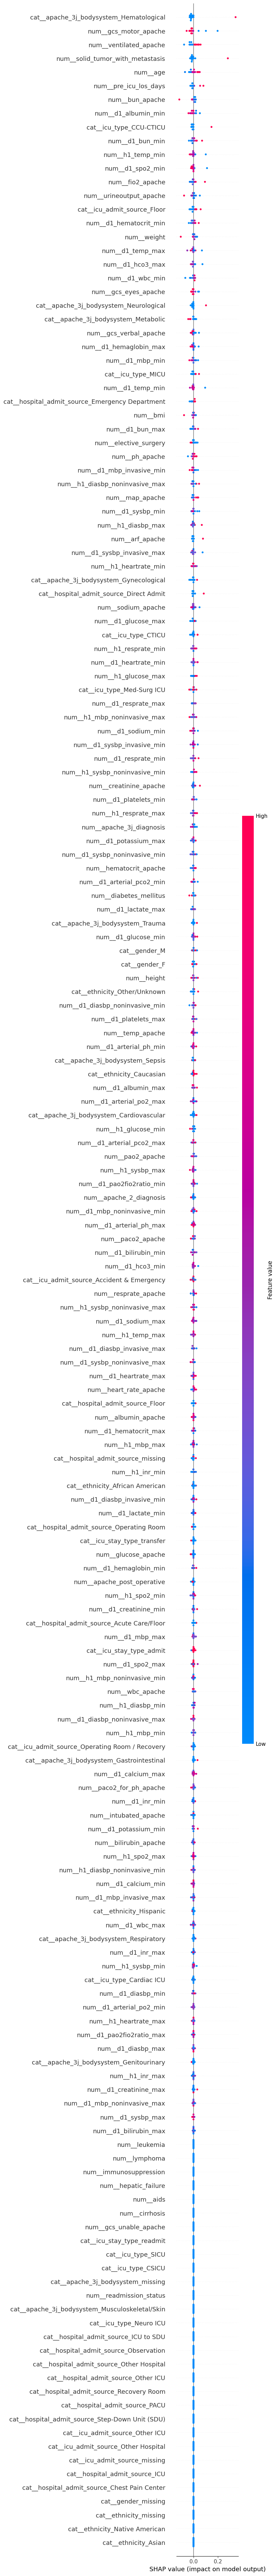

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(50, 40))
shap.summary_plot(shap_values, sample_X, feature_names=feature_names, max_display=len(feature_names))
plt.tight_layout()

plt.show()

In [ ]:
ethnicity_columns = [
    'cat__ethnicity_African American',
    'cat__ethnicity_Asian',
    'cat__ethnicity_Caucasian',
    'cat__ethnicity_Hispanic',
    'cat__ethnicity_Native American',
    'cat__ethnicity_Other/Unknown',
    'cat__ethnicity_missing'
]

#load the separated data to train and test the model.
X_train = pd.read_csv("/content/X_train.csv")
y_train = pd.read_csv("/content/y_train.csv")

X_val = pd.read_csv("/content/X_val.csv")
y_val = pd.read_csv("/content/y_val.csv")

X_test = pd.read_csv("/content/X_test.csv")
y_test = pd.read_csv("/content/y_test.csv")

In [ ]:
def get_ethnicity(row):
    for col in ethnicity_columns:
        if row[col] == 1:
            return col.split('__')[-1]
    return 'Unknown'

In [ ]:
X_train['ethnicity'] = X_train.apply(get_ethnicity, axis=1)
print(X_train['ethnicity'])

X_test['ethnicity'] = X_test.apply(get_ethnicity, axis=1)
print(X_test['ethnicity'])

0            ethnicity_Caucasian
1            ethnicity_Caucasian
2            ethnicity_Caucasian
3            ethnicity_Caucasian
4            ethnicity_Caucasian
                  ...           
17392            ethnicity_Asian
17393        ethnicity_Caucasian
17394    ethnicity_Other/Unknown
17395        ethnicity_Caucasian
17396        ethnicity_Caucasian
Name: ethnicity, Length: 17397, dtype: object
0              ethnicity_Caucasian
1       ethnicity_African American
2              ethnicity_Caucasian
3       ethnicity_African American
4              ethnicity_Caucasian
                   ...            
7245           ethnicity_Caucasian
7246           ethnicity_Caucasian
7247           ethnicity_Caucasian
7248           ethnicity_Caucasian
7249           ethnicity_Caucasian
Name: ethnicity, Length: 7250, dtype: object


In [ ]:
print(X_train['ethnicity'].value_counts())
eth = X_train['ethnicity'].unique()

ethnicity
ethnicity_Caucasian           13462
ethnicity_African American     1772
ethnicity_Other/Unknown         825
ethnicity_Hispanic              708
ethnicity_missing               242
ethnicity_Asian                 215
ethnicity_Native American       173
Name: count, dtype: int64


In [ ]:
print(X_test['ethnicity'].value_counts())
eth = X_test['ethnicity'].unique()

ethnicity
ethnicity_Caucasian           5608
ethnicity_African American     720
ethnicity_Other/Unknown        332
ethnicity_Hispanic             302
ethnicity_missing              121
ethnicity_Asian                102
ethnicity_Native American       65
Name: count, dtype: int64


In [ ]:
print(eth)

['ethnicity_Caucasian' 'ethnicity_African American' 'ethnicity_Hispanic'
 'ethnicity_Other/Unknown' 'ethnicity_Native American' 'ethnicity_missing'
 'ethnicity_Asian']


In [ ]:
ethnicities_encode = {x:y for y,x in enumerate(eth)}

In [ ]:
print(ethnicities_encode)

{'ethnicity_Caucasian': 0, 'ethnicity_African American': 1, 'ethnicity_Hispanic': 2, 'ethnicity_Other/Unknown': 3, 'ethnicity_Native American': 4, 'ethnicity_missing': 5, 'ethnicity_Asian': 6}


In [ ]:
for value in range(len(X_train['ethnicity'])):
  for eth, num in ethnicities_encode.items():
    if X_train['ethnicity'][value] == eth:
      X_train['ethnicity'][value] = num

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_train['ethnicity'][value] = num
<ipython-input-195-4499693c5b1b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ethnicity'][value] = num
<ipython-input-195-4499693c5b1b>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you ar

In [ ]:
for value in range(len(X_test['ethnicity'])):
  for eth, num in ethnicities_encode.items():
    if X_test['ethnicity'][value] == eth:
      X_test['ethnicity'][value] = num

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_test['ethnicity'][value] = num
<ipython-input-196-5ed80914e74f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ethnicity'][value] = num
<ipython-input-196-5ed80914e74f>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are 

In [ ]:
X_val['ethnicity'] = X_val.apply(get_ethnicity, axis=1)

In [ ]:
for value in range(len(X_val['ethnicity'])):
  for eth, num in ethnicities_encode.items():
    if X_val['ethnicity'][value] == eth:
      X_val['ethnicity'][value] = num

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_val['ethnicity'][value] = num
<ipython-input-198-c7b69ece1407>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['ethnicity'][value] = num
<ipython-input-198-c7b69ece1407>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are se

In [ ]:
print(X_train['ethnicity'])

0        0
1        0
2        0
3        0
4        0
        ..
17392    6
17393    0
17394    3
17395    0
17396    0
Name: ethnicity, Length: 17397, dtype: object


In [ ]:
ethnicity_train = X_train['ethnicity']  #store the ethnicity column
ethnicity_val = X_val['ethnicity']  #store the ethnicity column
ethnicity_test = X_test['ethnicity']

In [ ]:
#load the standard scaler.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(columns=['ethnicity']))
X_val_scaled = scaler.transform(X_val.drop(columns=['ethnicity']))
X_test_scaled = scaler.transform(X_test.drop(columns=['ethnicity']))
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [ ]:
X_train = pd.DataFrame(X_train_scaled, columns=X_train.drop(columns=['ethnicity']).columns)
X_train['ethnicity'] = ethnicity_train

X_val= pd.DataFrame(X_val_scaled, columns=X_val.drop(columns=['ethnicity']).columns)
X_val['ethnicity'] = ethnicity_val

X_test = pd.DataFrame(X_test_scaled, columns=X_test.drop(columns=['ethnicity']).columns)
X_test['ethnicity'] = ethnicity_test

In [ ]:
start_time = time.time()
svm_model = SVC(random_state=42, C=10, kernel='rbf', class_weight={0: 1, 1: weight})
svm_model.fit(X_train, y_train)
end_time = time.time()
y_pred = svm_model.predict(X_test)

training_time = end_time - start_time
print(f'Training took: {training_time} seconds for weight value {weight}')

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")

Training took: 198.81544280052185 seconds for weight value 5
Accuracy: 0.8357241379310345

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90      5694
           1       0.63      0.57      0.60      1556

    accuracy                           0.84      7250
   macro avg       0.76      0.74      0.75      7250
weighted avg       0.83      0.84      0.83      7250


Confusion Matrix:
 [[5178  516]
 [ 675  881]]
True Positive Rate (TPR): 0.5662
True Negative Rate (TNR): 0.9094


In [ ]:
y_scores = svm_model.decision_function(X_test)

In [ ]:
print(ethnicities_encode)

{'ethnicity_Caucasian': 0, 'ethnicity_African American': 1, 'ethnicity_Hispanic': 2, 'ethnicity_Other/Unknown': 3, 'ethnicity_Native American': 4, 'ethnicity_missing': 5, 'ethnicity_Asian': 6}


In [ ]:
#step 5: Compute metrics by group using MetricFrame
mf = MetricFrame(metrics={'Positive rate': selection_rate},
                 y_true=y_test,
                 y_pred=y_pred,
                 sensitive_features=X_test['ethnicity'])  # Use ethnicity from the scaled data

#display results by group
display(mf.by_group)
print("Overall SR: %.2f" % mf.overall[0])

#summarize demographic parity as the max difference between groups
print("Demographic parity diff: %.2f" % mf.difference(method='between_groups')[0])

#summarize demographic parity using the metric (this gives the exact same result as mf.difference())
dpd = demographic_parity_difference(y_true=y_test,
                                    y_pred=y_pred,
                                    sensitive_features=X_test['ethnicity'],
                                    method='between_groups')  #summarize as the max difference between any of the groups
print("Demographic parity diff: %.2f" % dpd)

,Positive rate
ethnicity,
0,0.190442
1,0.213889
2,0.231788
3,0.183735
4,0.123077
5,0.173554
6,0.147059


Overall SR: 0.19
Demographic parity diff: 0.11
Demographic parity diff: 0.11


<ipython-input-208-52dd12247849>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Overall SR: %.2f" % mf.overall[0])
<ipython-input-208-52dd12247849>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Demographic parity diff: %.2f" % mf.difference(method='between_groups')[0])


In [ ]:
#compute metrics
mf = MetricFrame(metrics =
                 {'false positive rate' : false_positive_rate,
                  'false negative rate' : false_negative_rate},
                 y_true=y_test,
                 y_pred=y_pred,
                 sensitive_features=X_test['ethnicity'])
display(mf.by_group)

#summarize differences
for i in mf.difference('between_groups').items():
    print("%s diff: %.2f" % i)

#alternatively: summarize equalized odds in one metric (which is the max of fpr diff and fnr diff)
dpd = equalized_odds_difference(y_test,
                                    y_pred,
                                    sensitive_features=X_test['ethnicity'],
                                    method='between_groups')
print("equalized odds diff: %.2f" % dpd)

,false positive rate,false negative rate
ethnicity,,
0,0.089796,0.439065
1,0.108108,0.430303
2,0.107759,0.357143
3,0.086142,0.415385
4,0.042553,0.666667
5,0.061224,0.347826
6,0.047059,0.352941


false positive rate diff: 0.07
false negative rate diff: 0.32
equalized odds diff: 0.32
